# TorchVision 0.3 DEEPLAB Finetuning

For this notebook, we will be finetuning a pre-trained DEEPLAB model in the Crack Forest Dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

This notebook has been inspired from both following links: [link 1](https://medium.com/technovators/semantic-segmentation-using-deeplabv3-ce68621e139e) and [link 2](https://expoundai.wordpress.com/2019/08/30/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch/)

In [ ]:
#we just cloned the repo in order to access the data easily and install the deps !

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zipAa

--2020-12-08 13:54:09--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  23.7MB/s    in 2.2s    

2020-12-08 13:54:12 (23.7 MB/s) - ‘PennFudanPed.zip.1’ saved [53723336/53723336]

--2020-12-08 13:54:12--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-12-08 13:54:12--
Total wall clock time: 2.5s
Downloaded: 1 files, 51M in 2.2s (23.7 MB/s)
Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one,

In [ ]:
cd /content

/content


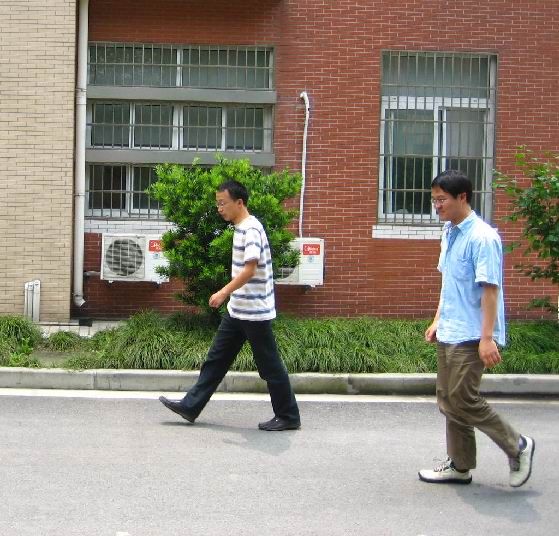

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')


In [ ]:
def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

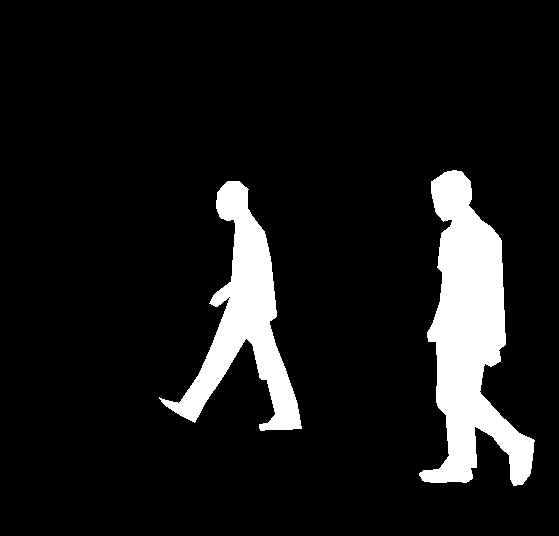

In [ ]:

mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 255, 255, # Crack is red
])
mask

In [ ]:
cd PennFudanPed/

/content/PennFudanPed


In [ ]:
mkdir PedMasks1

In [ ]:
cd /content

/content


In [ ]:
from PIL import Image 
from PIL import ImageFilter 
import os 

inPath= "/content/PennFudanPed/PedMasks" 
for imagePath in os.listdir(inPath):
  inputPath= os.path.join(inPath,imagePath)
  print(inputPath)
  img =Image.open(inputPath)
  img=colorize_mask(img)
  img.save(inputPath)

/content/PennFudanPed/PedMasks/FudanPed00041_mask.png
/content/PennFudanPed/PedMasks/FudanPed00018_mask.png
/content/PennFudanPed/PedMasks/PennPed00056_mask.png
/content/PennFudanPed/PedMasks/FudanPed00046_mask.png
/content/PennFudanPed/PedMasks/FudanPed00007_mask.png
/content/PennFudanPed/PedMasks/FudanPed00033_mask.png
/content/PennFudanPed/PedMasks/FudanPed00039_mask.png
/content/PennFudanPed/PedMasks/FudanPed00028_mask.png
/content/PennFudanPed/PedMasks/PennPed00060_mask.png
/content/PennFudanPed/PedMasks/FudanPed00051_mask.png
/content/PennFudanPed/PedMasks/PennPed00064_mask.png
/content/PennFudanPed/PedMasks/PennPed00023_mask.png
/content/PennFudanPed/PedMasks/PennPed00091_mask.png
/content/PennFudanPed/PedMasks/FudanPed00012_mask.png
/content/PennFudanPed/PedMasks/FudanPed00047_mask.png
/content/PennFudanPed/PedMasks/FudanPed00070_mask.png
/content/PennFudanPed/PedMasks/PennPed00068_mask.png
/content/PennFudanPed/PedMasks/FudanPed00004_mask.png
/content/PennFudanPed/PedMasks/Pen

#Data Loader
We use Torch Dataloader for loading the dataset and then apply some transformations that we are going to define by ourselves since our dataset returns a dictionary which will not work with the standard transforms provided by Torchvision 

In [ ]:
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset


class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "grayscale") -> None:
        """
        Args:
            root (str): Root directory path.
            image_folder (str): Name of the folder that contains the images in the root directory.
            mask_folder (str): Name of the folder that contains the masks in the root directory.
            transforms (Optional[Callable], optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.ToTensor`` for images. Defaults to None.
            seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
            fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
            subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.
            image_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'rgb'.
            mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
        Raises:
            OSError: If image folder doesn't exist in root.
            OSError: If mask folder doesn't exist in root.
            ValueError: If subset is not either 'Train' or 'Test'
            ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'
        """
        super().__init__(root, transforms)
        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )
        if mask_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{mask_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode

        if not fraction:
            self.image_names = sorted(image_folder_path.glob("*"))
            self.mask_names = sorted(mask_folder_path.glob("*"))
        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))
            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
seg_dataset = SegmentationDataset("PennFudanPed", "PNGImages", "PedMasks", transforms=transforms.Compose([transforms.Resize((559, 536)),transforms.ToTensor()]))
seg_dataloader = DataLoader(seg_dataset, batch_size=4, shuffle=False, num_workers=4)
#seg_dataloader = DataLoader(seg_dataset, batch_size=4, shuffle=False, num_workers=8)
samples = next(iter(seg_dataloader))
# Display the image and mask tensor shape
# We see the tensor size is correct bxcxhxw, where b is batch size, c is number of channels, h is height, w is width
display(samples['image'].shape,
samples['mask'].shape)


torch.Size([4, 3, 559, 536])

torch.Size([4, 1, 559, 536])

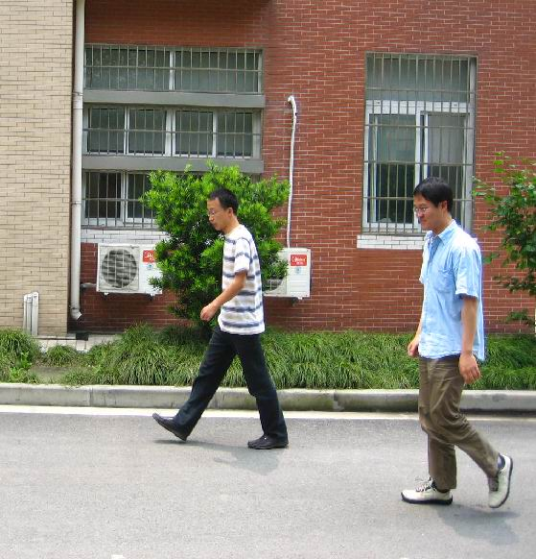

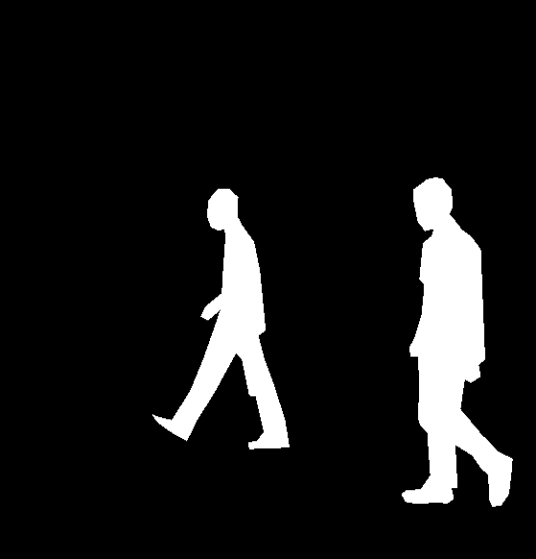

In [ ]:

img = transforms.ToPILImage()(samples['image'][0])
mask = transforms.ToPILImage()(samples['mask'][0])

display(img, mask)

# Define Our Baby Model

In [ ]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models



def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Tanh activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

# Prepare the Garden To play!

In [ ]:
import csv
import copy
import time
from tqdm import tqdm
import torch
import numpy as np
import os


def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            #print(dataloaders[phase].shape())
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                print("inputs__zina",inputs.shape)
                print("masks__zina",masks.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(
                phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = 'PNGImages',
                                 mask_folder: str = 'PedMasks',
                                 fraction: float = 0.2,
                                 batch_size: int = 4):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.
    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.
    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """
    data_transforms = transforms.Compose([transforms.Resize((559, 536)),transforms.ToTensor()])

    image_datasets = {
        x: SegmentationDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               seed=100,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8)
        for x in ['Train', 'Test']
    }
    return dataloaders

# Put Everything Together Guys!

In [ ]:
mkdir CFEXP1

In [ ]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score
import torch

#experience directory

bpath = '/content/CFEXP1'
#data directory
data_dir = '/content/PennFudanPed'
#epochs
#epochs = 100
epochs =25
#batchsize
batchsize = 4


# Create the deeplabv3 resnet101 model which is pretrained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
model = createDeepLabv3()
model.train()
# Create the experiment directory if not present
if not os.path.isdir(bpath):
    os.mkdir(bpath)


# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Specify the evalutation metrics
#metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}
metrics = {'f1_score': f1_score}

#Images/Masks!
# Create the dataloader
#dataloaders = get_dataloader_single_folder(data_dir, imageFolder='Images', maskFolder='Masks', fraction=0.2, batch_size=batchsize)
  # Create the dataloader
dataloaders =get_dataloader_single_folder(
        data_dir, batch_size=batchsize)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
trained_model = train_model(model, criterion, dataloaders,
                            optimizer, bpath=bpath, metrics=metrics, num_epochs=epochs)

Epoch 1/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:31,  6.40s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.22s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:18<03:08,  6.09s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:59,  6.00s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:51,  5.92s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:35<02:44,  5.87s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:41<02:37,  5.83s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:30,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:52<02:24,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:58<02:17,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:09<02:06,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:15<01:59,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:54,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:26<01:48,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:32<01:42,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:43<01:30,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:49<01:25,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [02:00<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:06<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:17<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:23<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:34<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:40<00:33,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:51<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:57<00:17,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:08<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:14<00:00,  5.72s/it]

Train Loss: 0.0469



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.48s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.34s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.25s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.17s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.13s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:17<00:00,  2.00s/it]


Test Loss: 0.0703
{'epoch': 1, 'Train_loss': 0.04693223908543587, 'Test_loss': 0.07025524973869324, 'Train_f1_score': 0.5855573489112915, 'Test_f1_score': 0.6241235956901019}
Epoch 2/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:30,  6.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:17,  6.17s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:06,  6.02s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.92s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.85s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0341



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.52s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.37s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.27s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]


Test Loss: 0.0339
{'epoch': 2, 'Train_loss': 0.034090809524059296, 'Test_loss': 0.03389931842684746, 'Train_f1_score': 0.5743106921202232, 'Test_f1_score': 0.7058449725635284}
Epoch 3/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:28,  6.31s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:15,  6.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:05,  5.99s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:56,  5.90s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:48,  5.82s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.79s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:44<00:28,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:01<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0283



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.50s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.37s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.27s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]


Test Loss: 0.0302
{'epoch': 3, 'Train_loss': 0.028312627226114273, 'Test_loss': 0.03023618273437023, 'Train_f1_score': 0.6861496069449606, 'Test_f1_score': 0.6506905659423265}
Epoch 4/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:32,  6.45s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.22s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.04s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.93s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.86s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:04,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:41,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:44<00:28,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:01<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0377



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:20,  2.58s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:16,  2.43s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:13,  2.30s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.22s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.17s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.00s/it]


Test Loss: 0.0183
{'epoch': 4, 'Train_loss': 0.037672873586416245, 'Test_loss': 0.01830063946545124, 'Train_f1_score': 0.6944784796494741, 'Test_f1_score': 0.7909456960465693}
Epoch 5/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:36,  6.55s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:21,  6.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:09,  6.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:59,  5.97s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:50,  5.87s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.81s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:23,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0151



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.51s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.37s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.26s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]


Test Loss: 0.0176
{'epoch': 5, 'Train_loss': 0.015072604641318321, 'Test_loss': 0.01758931577205658, 'Train_f1_score': 0.7533650314948526, 'Test_f1_score': 0.7992889009034214}
Epoch 6/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:28,  6.32s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:15,  6.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:05,  5.98s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:56,  5.89s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.83s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:04,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:41,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:36<01:36,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:53<01:19,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:10<01:02,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:27<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:44<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:17,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:01<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0172



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.53s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.37s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0405
{'epoch': 6, 'Train_loss': 0.017215484753251076, 'Test_loss': 0.0404670350253582, 'Train_f1_score': 0.794578695867258, 'Test_f1_score': 0.8083972900110545}
Epoch 7/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:27,  6.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:15,  6.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:05,  5.98s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:56,  5.89s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:28<02:48,  5.81s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:45<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:44<00:28,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0132



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.50s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.36s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.26s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]


Test Loss: 0.0096
{'epoch': 7, 'Train_loss': 0.013208835385739803, 'Test_loss': 0.009574186988174915, 'Train_f1_score': 0.8295192009254908, 'Test_f1_score': 0.8104862643821947}
Epoch 8/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:32,  6.43s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.04s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:58,  5.94s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.86s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:04,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:53<01:19,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:10<01:02,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:27<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:44<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:01<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0087



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.63s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.46s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:13,  2.33s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.24s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.18s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]

Test Loss: 0.0196
{'epoch': 8, 'Train_loss': 0.008661855012178421, 'Test_loss': 0.01955382339656353, 'Train_f1_score': 0.8289281450899864, 'Test_f1_score': 0.8135385464532024}
Epoch 9/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:35,  6.52s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:20,  6.27s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:08,  6.09s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:58,  5.97s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:50,  5.87s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.81s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0117



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.49s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.36s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.26s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.18s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.10s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]


Test Loss: 0.0094
{'epoch': 9, 'Train_loss': 0.011663827113807201, 'Test_loss': 0.009419890120625496, 'Train_f1_score': 0.8586506915350008, 'Test_f1_score': 0.8183906105526052}
Epoch 10/25
----------


  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:34,  6.49s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:19,  6.25s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:08,  6.07s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:58,  5.95s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:50,  5.87s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.81s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:17,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:04,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:41,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0080



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.57s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.40s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.10s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0330
{'epoch': 10, 'Train_loss': 0.007950113154947758, 'Test_loss': 0.033031634986400604, 'Train_f1_score': 0.8701736660820072, 'Test_f1_score': 0.8112235391622882}
Epoch 11/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:35,  6.52s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:20,  6.26s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:08,  6.09s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:59,  5.97s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:50,  5.87s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.82s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:36,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:23,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:17,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:09<02:05,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:26<01:48,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:43<01:30,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [02:00<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:17<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:34<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:51<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:17,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:08<00:05,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.71s/it]

Train Loss: 0.0094



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.48s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.35s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.26s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]

Test Loss: 0.0154
{'epoch': 11, 'Train_loss': 0.009354335255920887, 'Test_loss': 0.015436524525284767, 'Train_f1_score': 0.8761136716977653, 'Test_f1_score': 0.8219086985818252}
Epoch 12/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:36,  6.55s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:21,  6.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:09,  6.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:59,  5.97s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:50,  5.88s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:43,  5.82s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:23,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:17,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.64s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.64s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0076



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.79s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.56s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.39s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0196
{'epoch': 12, 'Train_loss': 0.007616840302944183, 'Test_loss': 0.01961221732199192, 'Train_f1_score': 0.8863197687907794, 'Test_f1_score': 0.8167878982298419}
Epoch 13/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:32,  6.43s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.05s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:58,  5.94s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.85s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:58,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:41,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0105



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.53s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.39s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.10s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0171
{'epoch': 13, 'Train_loss': 0.010460535995662212, 'Test_loss': 0.017083780840039253, 'Train_f1_score': 0.8839776089824443, 'Test_f1_score': 0.8124158853100626}
Epoch 14/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:38,  6.62s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:22,  6.34s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:10,  6.13s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:59,  5.99s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:51,  5.90s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:43,  5.84s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:23,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:17,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:41,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [02:00<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0068



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.52s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.37s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.27s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]

Test Loss: 0.0283
{'epoch': 14, 'Train_loss': 0.006841002497822046, 'Test_loss': 0.028258850798010826, 'Train_f1_score': 0.8893598186394939, 'Test_f1_score': 0.8207116847343541}
Epoch 15/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:33,  6.46s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:19,  6.22s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:08,  6.07s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:58,  5.95s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.85s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:17,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:17,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0081



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.54s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.39s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.10s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0160
{'epoch': 15, 'Train_loss': 0.00810026191174984, 'Test_loss': 0.01596888154745102, 'Train_f1_score': 0.8934834031672085, 'Test_f1_score': 0.8107819367255829}
Epoch 16/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:27,  6.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:15,  6.10s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:05,  5.98s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:56,  5.88s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:28<02:48,  5.82s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:17,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0079



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.79s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.57s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.40s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.22s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.17s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:15<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.10s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.03s/it]

Test Loss: 0.0172
{'epoch': 16, 'Train_loss': 0.007888744585216045, 'Test_loss': 0.017216486856341362, 'Train_f1_score': 0.8966884234334842, 'Test_f1_score': 0.8150598005472831}
Epoch 17/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:31,  6.42s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.05s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:58,  5.94s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.86s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:17,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:48,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0066



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.79s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.57s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.42s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.31s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.22s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:13<00:06,  2.17s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:15<00:04,  2.13s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.11s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.03s/it]

Test Loss: 0.0247
{'epoch': 17, 'Train_loss': 0.006553398445248604, 'Test_loss': 0.02468201145529747, 'Train_f1_score': 0.8994519591048539, 'Test_f1_score': 0.8163158127008675}
Epoch 18/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:26,  6.26s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:14,  6.09s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:04,  5.95s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:56,  5.87s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:28<02:48,  5.81s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:34,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:45<02:28,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:02<02:10,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:17,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0093



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.53s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0249
{'epoch': 18, 'Train_loss': 0.009287944063544273, 'Test_loss': 0.024935243651270866, 'Train_f1_score': 0.9000967290012707, 'Test_f1_score': 0.817550687839765}
Epoch 19/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:31,  6.42s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.04s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.93s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.85s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0078



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.55s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.39s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0562
{'epoch': 19, 'Train_loss': 0.007821948267519474, 'Test_loss': 0.05623083934187889, 'Train_f1_score': 0.9018531373191523, 'Test_f1_score': 0.8113934517938712}
Epoch 20/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:31,  6.42s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.04s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.93s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.86s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.81s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0056



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.55s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.39s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.29s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0198
{'epoch': 20, 'Train_loss': 0.005627280566841364, 'Test_loss': 0.019834334030747414, 'Train_f1_score': 0.9028430418627759, 'Test_f1_score': 0.8132202819466705}
Epoch 21/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:28,  6.31s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:15,  6.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:05,  5.99s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:56,  5.89s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:28<02:48,  5.82s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:11,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:17,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0103



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.53s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]

Test Loss: 0.0301
{'epoch': 21, 'Train_loss': 0.010262708179652691, 'Test_loss': 0.030070744454860687, 'Train_f1_score': 0.9036976383870777, 'Test_f1_score': 0.8187227443431221}
Epoch 22/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:30,  6.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:17,  6.17s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:06,  6.02s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.91s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.84s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.79s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0057



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.53s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0132
{'epoch': 22, 'Train_loss': 0.0057159424759447575, 'Test_loss': 0.013169153593480587, 'Train_f1_score': 0.9035902181439575, 'Test_f1_score': 0.817699615932832}
Epoch 23/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:30,  6.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:17,  6.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:06,  6.03s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.92s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.84s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.78s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:28,  5.73s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.69s/it]

Train Loss: 0.0058



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.51s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.37s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.14s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.08s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.01s/it]

Test Loss: 0.0181
{'epoch': 23, 'Train_loss': 0.005760566797107458, 'Test_loss': 0.018098264932632446, 'Train_f1_score': 0.9046935615944424, 'Test_f1_score': 0.816409890415479}
Epoch 24/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:24,  6.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:11<03:13,  6.03s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:03,  5.92s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:55,  5.84s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:28<02:48,  5.80s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:41,  5.75s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:34,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:45<02:28,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.70s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:02<02:10,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:04,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:19<01:53,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:41,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:36<01:36,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:24,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:53<01:19,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:07,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:10<01:02,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:50,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:27<00:45,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:33,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:44<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:55<00:16,  5.64s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:01<00:11,  5.65s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.68s/it]

Train Loss: 0.0052



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:22,  2.77s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.55s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.38s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.21s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.15s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.11s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:16<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]

Test Loss: 0.0119
{'epoch': 24, 'Train_loss': 0.005184809677302837, 'Test_loss': 0.01192481815814972, 'Train_f1_score': 0.9051709409852432, 'Test_f1_score': 0.8154134478320257}
Epoch 25/25
----------



  0%|          | 0/34 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  3%|▎         | 1/34 [00:06<03:31,  6.42s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  6%|▌         | 2/34 [00:12<03:18,  6.19s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


  9%|▉         | 3/34 [00:17<03:07,  6.04s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 12%|█▏        | 4/34 [00:23<02:57,  5.93s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 15%|█▍        | 5/34 [00:29<02:49,  5.85s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 18%|█▊        | 6/34 [00:34<02:42,  5.79s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 21%|██        | 7/34 [00:40<02:35,  5.76s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 24%|██▎       | 8/34 [00:46<02:29,  5.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 26%|██▋       | 9/34 [00:51<02:22,  5.72s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 29%|██▉       | 10/34 [00:57<02:16,  5.71s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 32%|███▏      | 11/34 [01:03<02:10,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 35%|███▌      | 12/34 [01:08<02:05,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 38%|███▊      | 13/34 [01:14<01:59,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 41%|████      | 14/34 [01:20<01:53,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 15/34 [01:25<01:47,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 47%|████▋     | 16/34 [01:31<01:42,  5.69s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 50%|█████     | 17/34 [01:37<01:36,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 53%|█████▎    | 18/34 [01:42<01:30,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 19/34 [01:48<01:25,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 59%|█████▉    | 20/34 [01:54<01:19,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 62%|██████▏   | 21/34 [01:59<01:13,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 65%|██████▍   | 22/34 [02:05<01:08,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 68%|██████▊   | 23/34 [02:11<01:02,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 71%|███████   | 24/34 [02:16<00:56,  5.68s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 74%|███████▎  | 25/34 [02:22<00:51,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 76%|███████▋  | 26/34 [02:28<00:45,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 79%|███████▉  | 27/34 [02:33<00:39,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 82%|████████▏ | 28/34 [02:39<00:34,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 85%|████████▌ | 29/34 [02:45<00:28,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 88%|████████▊ | 30/34 [02:50<00:22,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 91%|█████████ | 31/34 [02:56<00:16,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 94%|█████████▍| 32/34 [03:02<00:11,  5.67s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 97%|█████████▋| 33/34 [03:07<00:05,  5.66s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


100%|██████████| 34/34 [03:13<00:00,  5.70s/it]

Train Loss: 0.0062



  0%|          | 0/9 [00:00<?, ?it/s]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 11%|█         | 1/9 [00:02<00:21,  2.74s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 22%|██▏       | 2/9 [00:04<00:17,  2.53s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 33%|███▎      | 3/9 [00:06<00:14,  2.39s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 44%|████▍     | 4/9 [00:08<00:11,  2.28s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 56%|█████▌    | 5/9 [00:10<00:08,  2.20s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 67%|██████▋   | 6/9 [00:12<00:06,  2.16s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 78%|███████▊  | 7/9 [00:14<00:04,  2.12s/it]

inputs__zina torch.Size([4, 3, 559, 536])
masks__zina torch.Size([4, 1, 559, 536])


 89%|████████▉ | 8/9 [00:17<00:02,  2.09s/it]

inputs__zina torch.Size([2, 3, 559, 536])
masks__zina torch.Size([2, 1, 559, 536])


100%|██████████| 9/9 [00:18<00:00,  2.02s/it]


Test Loss: 0.0119
{'epoch': 25, 'Train_loss': 0.006155500654131174, 'Test_loss': 0.011935903690755367, 'Train_f1_score': 0.9052594834727931, 'Test_f1_score': 0.8177997710487691}
Training complete in 88m 38s
Lowest Loss: 0.009420


In [ ]:

# Save the trained model
# torch.save({'model_state_dict':trained_model.state_dict()},os.path.join(bpath,'weights'))
torch.save(model, os.path.join(bpath, 'weights.pt'))

# Now let's test our results!

#Load Already trained model!(weights)

In [ ]:
cd /content

/content


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#2. Get the file
downloaded = drive.CreateFile({'id':"1oRNR1Li-vjNWRPifYA8fNtAeG-9PCuBf"})   # replace the id with id of file you want to access
downloaded.GetContentFile('CFEXP_10_EP.zip')

In [ ]:
%%shell
unzip /content/CFEXP_10_EP.zip

Archive:  /content/CFEXP_10_EP.zip
  inflating: deeplabv3/log.csv       
  inflating: deeplabv3/weights.pt    


In [ ]:
#Load our model
pathweights='/content/CFEXP1/weights.pt'
#pathweights='/content/DeepLabv3FineTuning/deeplabv3/weights.pt'
model= torch.load(pathweights)
#set the mode to the evaluate mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
#Read the log file using pandas into a dataframe
pathlogs='/content/CFEXP1/log.csv'
#pathlogs='/content/DeepLabv3FineTuning/deeplabv3/log.csv'
import pandas as pd
df= pd.read_csv(pathlogs)

Training and testing loss, f1 score and auroc values for the model trained on the Crack Forest Dataset

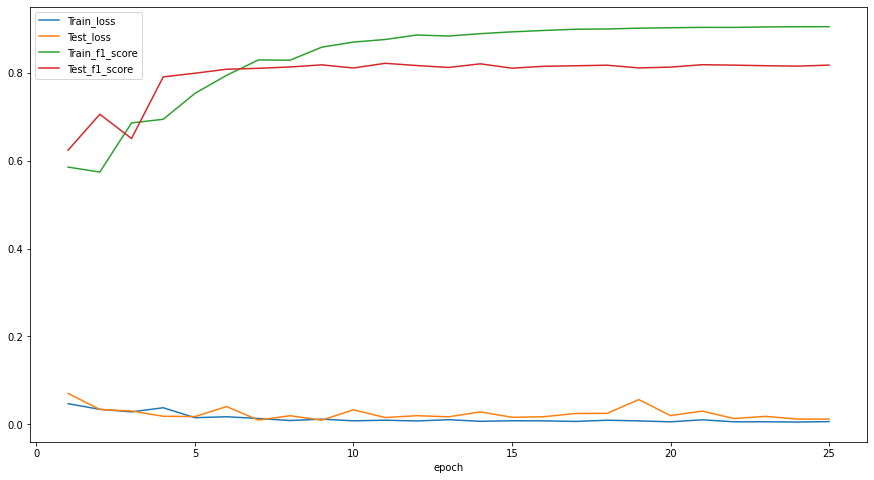

In [ ]:
#plot all the values for the model trained on the crackforest dataset 
df.plot(x='epoch',figsize=(15,8));

In [ ]:
df

,epoch,Train_loss,Test_loss,Train_f1_score,Test_f1_score
0,1,0.046932,0.070255,0.585557,0.624124
1,2,0.034091,0.033899,0.574311,0.705845
2,3,0.028313,0.030236,0.686150,0.650691
3,4,0.037673,0.018301,0.694478,0.790946
4,5,0.015073,0.017589,0.753365,0.799289
5,6,0.017215,0.040467,0.794579,0.808397
6,7,0.013209,0.009574,0.829519,0.810486
7,8,0.008662,0.019554,0.828928,0.813539
8,9,0.011664,0.009420,0.858651,0.818391
9,10,0.007950,0.033032,0.870174,0.811224


In [ ]:
print(df[['Train_f1_score','Test_f1_score']].max())

Train_f1_score    0.905259
Test_f1_score     0.821909
dtype: float64


#Sample Prediction

In [ ]:
import cv2
ino = 2
# Read  a sample image and mask from the data-set
img = cv2.imread(f'./PennFudanPed/PNGImages/FudanPed00001.png').transpose(2,0,1).reshape(1,3, 536, 559)
mask = cv2.imread(f'./PennFudanPed/PedMasks/FudanPed00001_mask.png')
with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)

(array([  2079., 259836.,   4710.,   2809.,   2617.,   2609.,   2925.,
          9480.,  11727.,    832.]),
 array([-0.23929688, -0.08949731,  0.06030226,  0.21010183,  0.3599014 ,
         0.50970095,  0.65950054,  0.8093001 ,  0.95909965,  1.1088992 ,
         1.2586988 ], dtype=float32),
 <a list of 10 Patch objects>)

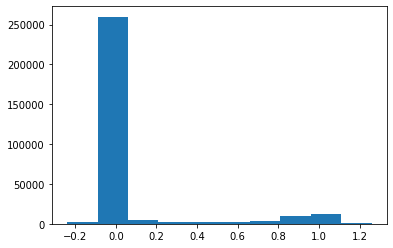

In [ ]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
import matplotlib.pyplot as plt
plt.hist(a['out'].data.cpu().numpy().flatten())

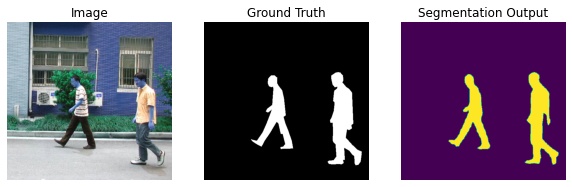

In [ ]:

# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
#plt.imshow(img[0,...].transpose(1,2,0));
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(a['out'].cpu().detach().numpy()[0][0]>0.5);
plt.title('Segmentation Output')
plt.axis('off');
